# Pytorch with the MNIST Dataset - MINST

In [2]:
## import libraries
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [3]:
print(torch.__version__)

2.1.1+cpu


In [4]:
args={}
kwargs={}
args['batch_size']=32
args['test_batch_size']=32
args['epochs']=1  #The number of Epochs is the number of times you go through the full dataset.
args['lr']=0.01 #Learning rate is how fast it will decend.
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).

args['seed']=1 #random seed
args['log_interval']=10
args['cuda']=False #if the computer has a GPU, type True, otherwise, False

This code is adopted from the pytorch examples repository. It is licensed under BSD 3-Clause "New" or "Revised" License. Source: https://github.com/pytorch/examples/ LICENSE: https://github.com/pytorch/examples/blob/master/LICENSE

## Load Dataset
The first step before training the model is to import the data. We will use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) which is like the Hello World dataset of machine learning.

Besides importing the data, we will also do a few more things:
- We will tranform the data into tensors using the `transforms` module
- We will use `DataLoader` to build convenient data loaders or what are referred to as iterators, which makes it easy to efficiently feed data in batches to deep learning models.
- As hinted above, we will also create batches of the data by setting the `batch` parameter inside the data loader. Notice we use batches of `32` in this tutorial but you can change it to `64` if you like. I encourage you to experiment with different batches.

In [5]:
## transformations
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

## download and load training dataset
trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=args['batch_size'], shuffle=True, **kwargs)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=args['test_batch_size'], shuffle=True, **kwargs)

## Exploring the Data
As a practioner and researcher, I am always spending a bit of time and effort exploring and understanding the dataset. It's fun and this is a good practise to ensure that everything is in order.

Let's check what the train and test dataset contains. I will use `matplotlib` to print out some of the images from our dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


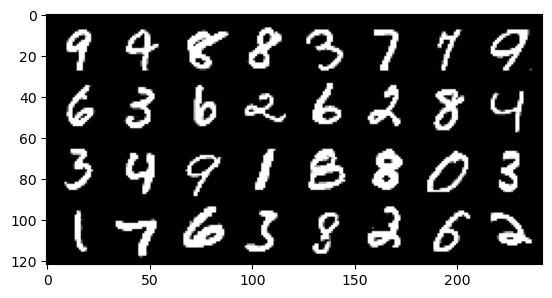

In [6]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

## show images
imshow(torchvision.utils.make_grid(images))

Let's check the dimensions of a batch.

In [7]:
for images, labels in train_loader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


## The Model
We provide two fully-connected neural net as the initial architecture.

Here are a few notes for those who are beginning with PyTorch:
- The model below consists of an `__init__()` portion which is where you include the layers and components of the neural network. In our model, we have two fully-connected netork network. We are dealing with an image dataset that is in a grayscale so we only need one channel going in, hence `in_channels=1`.

- After the first layer, we also apply an activation function such as `ReLU`. For prediction purposes, we then apply a `softmax` layer to the last transformation and return the output of that.  

In [8]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x=x.view(-1,784)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        #Softmax gets probabilities.
        return F.log_softmax(x, dim=1)


**Now, add one CNN layer with a pooling to the above neural network and rerun the code to see whether you get higher prediction accuracy on the test set.**

For example, you may try `out_channels=32`. Kernel size is 5, and for the rest of parameters we use the default values which you can find [here](https://pytorch.org/docs/stable/nn.html?highlight=conv2d#conv2d).

- In short, the convolutional layer transforms the input data into a specific dimension that has to be considered in the linear layer.

Make sure your flatten the output of CNN layer excluding # of batch so that the input of each example/batch has the same size of the first neural net.

Tips: You can use x.view(-1, # of input size of the first fully-connected layer) or you can use torch.flatten(x, 1).

I always encourage to test the model with 1 batch to ensure that the output dimensions are what we expect.

In [15]:
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        # CNN层
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        # 池化层
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 如果输入图像尺寸是28x28，经过一层卷积（padding=0）和池化后，尺寸变为：(28-5+1)/2 = 12
        self.fc1 = nn.Linear(32 * 12 * 12, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # CNN层和池化层
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)  # 或者 x = x.view(-1, 32 * 12 * 12)
        # 全连接层
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = CNNNet()
print(model)

CNNNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [22]:
class CNNNetExp3(nn.Module):
    def __init__(self):
        super(CNNNetExp3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
model = CNNNetExp3()
print(model)

CNNNetExp3(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [23]:
class CNNNetExp4(nn.Module):
    def __init__(self):
        super(CNNNetExp4, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 12 * 12, 512) # 增加隐藏单元数
        self.fc2 = nn.Linear(512, 128) # 新增一个全连接层
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
    
model = CNNNetExp4()
print(model)

CNNNetExp4(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [25]:
## test the model with 1 batch
# model = Net()
# model = CNNNet()
# model = CNNNetExp3()
model = CNNNetExp4()
#print(model)
for images, labels in train_loader:
    print("batch size:", args['batch_size'])
    out = model(images)
    print(out.shape)
    break

batch size: 32
torch.Size([32, 10])


## Training the Model
Now we are ready to train the model.

In [17]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        #Variables in Pytorch are differenciable.
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch.
        optimizer.zero_grad()
        output = model(data)
        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss = F.nll_loss(output, target)
        #dloss/dx for every Variable
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically.
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [18]:
def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
      for data, target in test_loader:
          if args['cuda']:
              data, target = data.cuda(), target.cuda()
          data, target = Variable(data), Variable(target)
          output = model(data)
          test_loss += F.nll_loss(output, target, size_average=False).data.item() # sum up batch loss
          pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
          correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [26]:
# model = Net()
# model = CNNNet()
# model = CNNNetExp3()
model = CNNNetExp4()
if args['cuda']:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309868
Train Epoch: 1 [320/60000 (1%)]	Loss: 2.219072
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.062630
Train Epoch: 1 [960/60000 (2%)]	Loss: 1.864384
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.623126
Train Epoch: 1 [1600/60000 (3%)]	Loss: 1.365099
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.130287
Train Epoch: 1 [2240/60000 (4%)]	Loss: 1.052206
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.720222
Train Epoch: 1 [2880/60000 (5%)]	Loss: 0.592717
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.638590
Train Epoch: 1 [3520/60000 (6%)]	Loss: 0.644765
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.507787
Train Epoch: 1 [4160/60000 (7%)]	Loss: 0.695003
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.302005
Train Epoch: 1 [4800/60000 (8%)]	Loss: 0.331780
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.439032
Train Epoch: 1 [5440/60000 (9%)]	Loss: 0.281746
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.291759
Train Epoch: 1 [6080/60000 (10%)]	Loss: 0.423406
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.34